# Identification of Deepfaked Images (and Videos?)
## By Li Run & Rongyi

This project aims to train an AI model to be able to identify deepfaked images from real ones with an accuracy of >=XX%.

## Data Collection

We utilized two datasets of images for training our model:
1. https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
2. https://www.kaggle.com/datasets/dagnelies/deepfake-faces

The first dataset contains approximately 70,000 training images, 5400 test images and 20,000 validation images of faces for both Real and Fake images each.

The second dataset contains approximately 95,600 images of faces. Labelling of the images as real or fake can be found under `metadata.csv`.

## Data Preprocessing

Let us first inspect the contents of `deepfake_faces`.

In [2]:
# Imports
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import random
from sklearn.utils.class_weight import compute_class_weight
import os, os.path, shutil
from tqdm import tqdm
import cv2

In [3]:
df = pd.read_csv('/kaggle/input/deepfake-faces/metadata.csv')
df.head()

,videoname,original_width,original_height,label,original
0,aznyksihgl.mp4,129,129,FAKE,xnojggkrxt.mp4
1,gkwmalrvcj.mp4,129,129,FAKE,hqqmtxvbjj.mp4
2,lxnqzocgaq.mp4,223,217,FAKE,xjzkfqddyk.mp4
3,itsbtrrelv.mp4,186,186,FAKE,kqvepwqxfe.mp4
4,ddvgrczjno.mp4,155,155,FAKE,pluadmqqta.mp4


In [4]:
df[df.videoname == 'aaagqkcdis.mp4']

,videoname,original_width,original_height,label,original
18722,aaagqkcdis.mp4,90,89,FAKE,eklsrnkwog.mp4


We took the name of the first image `aaaqgkcdis.jpg` and looked it up in`metadata.csv`, confirming that the image names corresponded to entries within the csv file allowing us to label the images ourselves.

In [5]:
df['label'].value_counts()

label
FAKE    79341
REAL    16293
Name: count, dtype: int64

From here we can see that the Fake:Real ratio in `deepfake_faces` is about 5:1. We need to handle this class imbalance in our data, which we will do by just taking a sample of 16,000 images from each Fake and Real instead. We also needs to categorise the images since they have not been labelled in the same format as in `deepfake-and-real-images`.


In [6]:
# NOTE: Run if output working folder is still empty

folder_path = '/kaggle/input/deepfake-faces/faces_224/'

os.makedirs('/kaggle/working/deepfake-faces/Fake', exist_ok=True)
os.makedirs('/kaggle/working/deepfake-faces/Real', exist_ok=True)   

realcount = 0
fakecount = 0
for index, row in tqdm(df.iterrows()):
    img_name = row['videoname'].split('.')[0] + '.jpg'
    old_path = folder_path + img_name
    if row['label'] == 'REAL':
        if realcount < 16000:
            new_path = os.path.join('/kaggle/working/deepfake-faces/Real', img_name)
            realcount += 1
        else:
            continue

    else:
        if fakecount < 16000:
            new_path = os.path.join('/kaggle/working/deepfake-faces/Fake', img_name)
            fakecount += 1
        else:
            continue
    
    shutil.copy(old_path, new_path)

    
print("Categorisation complete")
        

95634it [04:46, 333.87it/s] 

Categorisation complete


Let us test if our categorisation worked.

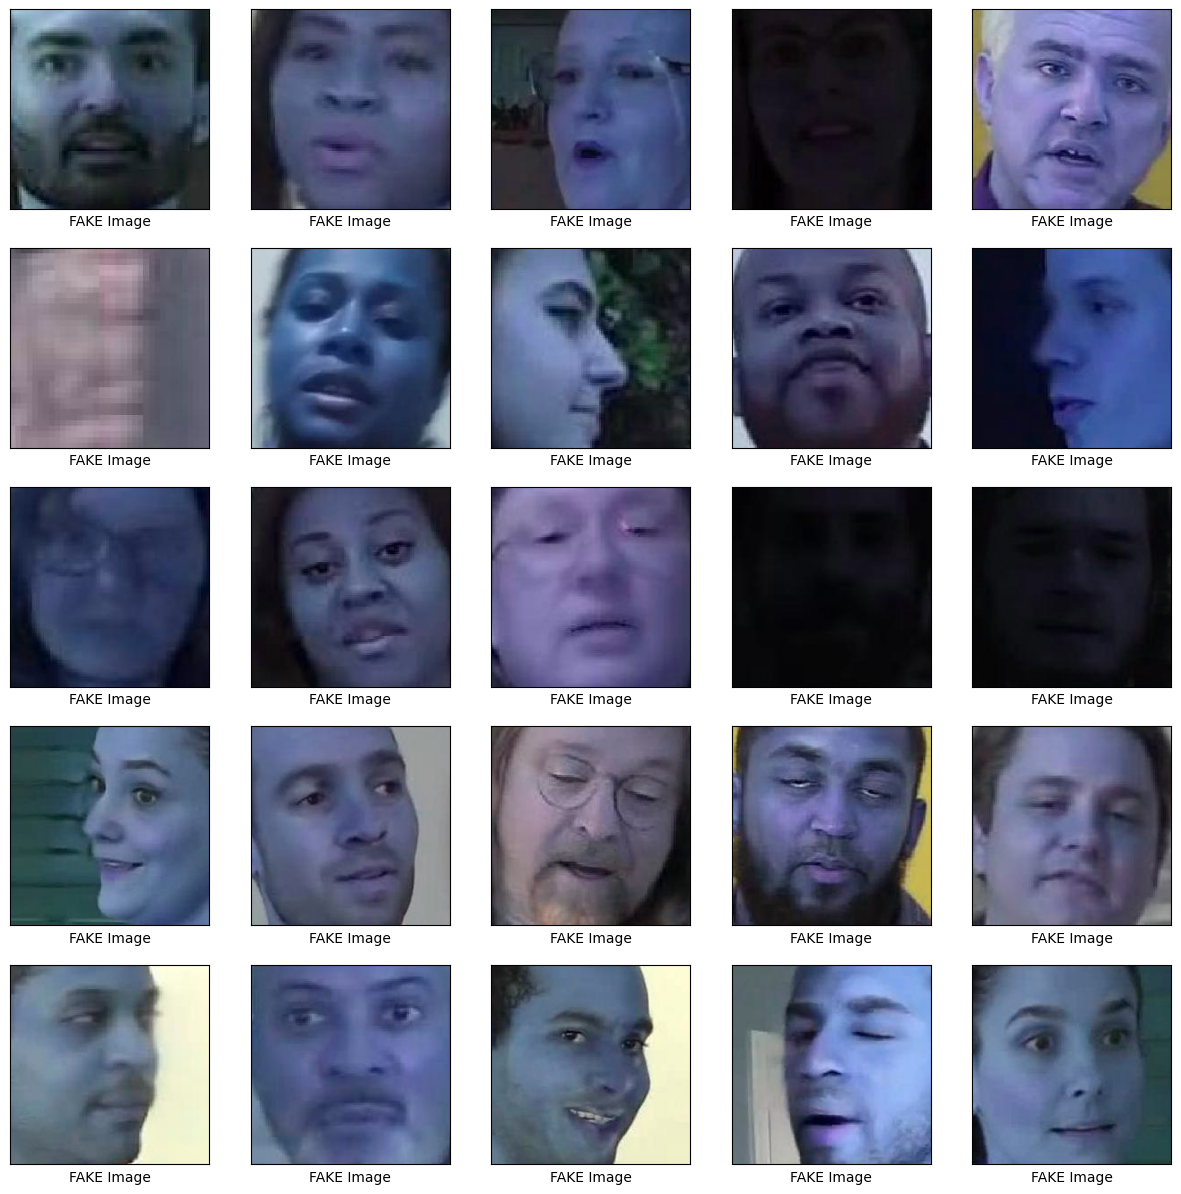

In [7]:
plt.figure(figsize=(15,15))
file_names = os.listdir('/kaggle/working/deepfake-faces/Fake/')
for i in range(25):
    idx = random.randint(0, len(file_names)) #take a random batch out of all the fake images
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    
    video_name = file_names[idx][:-4] + '.mp4'
    plt.imshow(cv2.imread('/kaggle/working/deepfake-faces/Fake/'+ file_names[idx]))
    # Redundant but i want to test if any real images made it in by some miracle
    if(df[df.videoname == video_name].iloc[0]['label']=='FAKE'):
        plt.xlabel('FAKE Image')
    else:
        plt.xlabel('REAL Image')
        
plt.show()

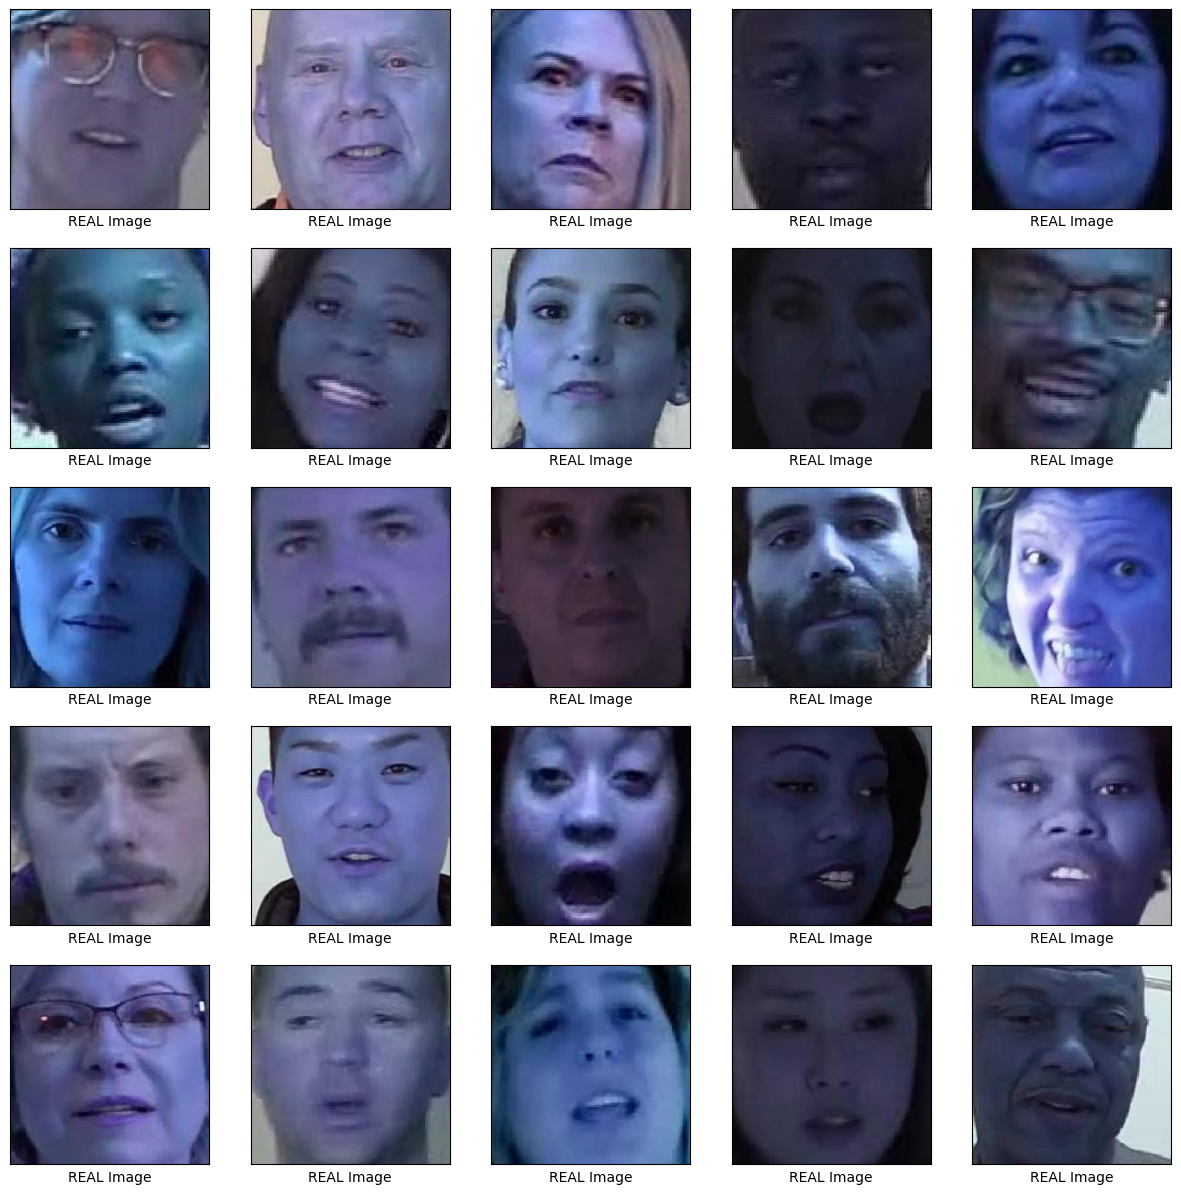

In [8]:
plt.figure(figsize=(15,15))
file_names = os.listdir('/kaggle/working/deepfake-faces/Real/')
for i in range(25):
    idx = random.randint(0, len(file_names)) #take a random batch out of all the fake images
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    
    video_name = file_names[idx][:-4] + '.mp4'
    plt.imshow(cv2.imread('/kaggle/working/deepfake-faces/Real/'+ file_names[idx]))
    # Redundant but i want to test if any fake images made it in by some miracle
    if(df[df.videoname == video_name].iloc[0]['label']=='FAKE'):
        plt.xlabel('FAKE Image')
    else:
        plt.xlabel('REAL Image')
        
plt.show()

As we can see from above, we have successfully separated the image files into 2 different subdirectories, `deepfake-faces/Real` and `deepfake-faces/Fake`.

Next, we will organize the data into their appropriate categories before splitting them into training and test/validation data.

This is achieved by splitting the images from `deepfake_and_real_images` into their training/validation/test sets first since those have already been organised for us, then adding on the images from `deepfake_faces`.

In [9]:
train = tf.keras.utils.image_dataset_from_directory('/kaggle/input/deepfake-and-real-images/Dataset/Train', labels = 'inferred', image_size=(224,224),)
val = tf.keras.utils.image_dataset_from_directory('/kaggle/input/deepfake-and-real-images/Dataset/Validation', labels = 'inferred', image_size=(224,224),)
test =  tf.keras.utils.image_dataset_from_directory('/kaggle/input/deepfake-and-real-images/Dataset/Test', labels = 'inferred', image_size=(224,224),)

print(train.class_names)

Found 140002 files belonging to 2 classes.
Found 39428 files belonging to 2 classes.
Found 10905 files belonging to 2 classes.
['Fake', 'Real']


In [10]:
deepfake_faces = tf.keras.utils.image_dataset_from_directory('/kaggle/working/deepfake-faces', labels='inferred', image_size=(224,224),)

print(deepfake_faces.class_names)



Found 32000 files belonging to 2 classes.
['Fake', 'Real']


In [11]:
deepfake_faces = deepfake_faces.shuffle(10, reshuffle_each_iteration=True)

train_size = int(0.7 * len(deepfake_faces))
test_size = int(0.15 * len(deepfake_faces))
val_size = int(0.15 * len(deepfake_faces))

train2 = deepfake_faces.take(train_size)
test2 = deepfake_faces.skip(train_size)
val2 = test2.skip(val_size)
test2 = test2.take(test_size)

train_merged = train.concatenate(train2)
val_merged = val.concatenate(val2)
test_merged = test.concatenate(test2)

# print(train_merged.class_names)
print(len(train_merged), len(train), len(train2))
print(len(train_merged), len(val_merged), len(test_merged))

5076 4376 700
5076 1383 491


To cut down on training time due to lack of resources to handle 100,000+ images easily, let us take a sample of 20,000 images for training, 

We are now done with merging our datasets, and can move on to training our model.

## Training of Model

## Do we want to do transfer learning or try our own architecture first lol

We perform further preprocessing on the image by normalising our data.

In [12]:
#Rescaling and Resizing
rescale_and_resize = tf.keras.models.Sequential([
    tf.keras.layers.Resizing(224,224),
    tf.keras.layers.Rescaling(1./255)
])

In [13]:
data_augmentation = tf.keras.models.Sequential([
    tf.keras.layers.RandomRotation(0.2),
])

In [14]:
model = tf.keras.models.Sequential([
#     tf.keras.Input(shape=(224,224,3)),
    
    rescale_and_resize,
    data_augmentation,

    
    tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu'),
    tf.keras.layers.Conv2D(32, kernel_size=3,activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=[2,2], strides=(2,2)),
    
    tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu'),
    tf.keras.layers.Conv2D(64, kernel_size=3,activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=[2,2], strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2), #there are 2 different classes 
])


model.compile(optimizer=tf._optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy']
             )

In [ ]:
# class CustomCallback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs={}):
#     if(logs.get('val_accuracy') >= 0.75):
#       print("Accuracy>=75%. Cancelling training.")
# acc_limit_callback = CustomCallback()


checkpoint_filepath = '/kaggle/working/output-models/original.model.keras'
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)
callback_list = [checkpoint_callback]

In [15]:
history = model.fit(
    train,
    validation_data=val,
    epochs=20,
    callbacks=callback_list
)

Epoch 1/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 389s 87ms/step - accuracy: 0.7183 - loss: 0.5530 - val_accuracy: 0.8197 - val_loss: 0.4112
Epoch 2/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 326s 74ms/step - accuracy: 0.8706 - loss: 0.2976 - val_accuracy: 0.8663 - val_loss: 0.3071
Epoch 3/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 326s 74ms/step - accuracy: 0.9034 - loss: 0.2300 - val_accuracy: 0.8961 - val_loss: 0.2449
Epoch 4/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 326s 74ms/step - accuracy: 0.9194 - loss: 0.1963 - val_accuracy: 0.9033 - val_loss: 0.2307
Epoch 5/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 326s 74ms/step - accuracy: 0.9275 - loss: 0.1747 - val_accuracy: 0.8855 - val_loss: 0.2807
Epoch 6/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 325s 74ms/step - accuracy: 0.9337 - loss: 0.1613 - val_accuracy: 0.9138 - val_loss: 0.2179
Epoch 7/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 326s 75ms/step - accuracy: 0.9389 - loss: 0.1506 - val_accuracy: 0.9050 - val_loss: 0.2286
Epoch 8/20
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 325s 74ms/step - accuracy: 

491/491 ━━━━━━━━━━━━━━━━━━━━ 27s 54ms/step


array([[18.446224 ,  5.0958633],
       [ 2.2445636,  5.1073136],
       [ 1.1356992,  2.82499  ],
       ...,
       [ 2.0583072, -2.0758114],
       [ 1.28918  , -1.926582 ],
       [ 3.8996577,  1.5375922]], dtype=float32)